In [1]:
import numpy as np 
import pandas as pd 
import os

# Importing Libraries

In [2]:
import cv2
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.utils.class_weight import compute_class_weight


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dropout, Dense, MaxPooling2D
from tensorflow.keras import Sequential

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.applications.resnet import preprocess_input
import tqdm 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Flatten)

from tensorflow.keras.layers import (Dense, Lambda, Dropout, Activation)
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import datasets, layers, models

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

%matplotlib inline

# EDA

In [3]:
## Read styles dataset
df = pd.read_csv("../Dataset/archive/styles.csv",error_bad_lines=False)
df.head()

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [4]:
### Printing all columns of the dataset
all_columns = df.columns
numerical_columns = [x for x in df.columns if df[x].dtype in ["int64","float64"]]
categorical_columns = [x for x in df.columns if df[x].dtype in ["object"]]
print(all_columns)
print(numerical_columns)
print(categorical_columns)

print("\n\n")
print("All columns shape",df.shape[1])
print("Numerical columns shape",len(numerical_columns))
print("Categotical columns shape",len(categorical_columns))

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')
['id', 'year']
['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'usage', 'productDisplayName']



All columns shape 10
Numerical columns shape 2
Categotical columns shape 8


# Preprocessing

## 1. Handling Imbalance in dataset

In [5]:
## Gender
df['gender'].value_counts(ascending=False)
## Have to upsample images for unisex, boys, girls
## required columns = ['Men','Women','Unisex']

Men       22147
Women     18631
Unisex     2161
Boys        830
Girls       655
Name: gender, dtype: int64

In [6]:
## masterCategory
df['masterCategory'].value_counts(ascending=False)
## Can drop ['Free Items','Sporting Goods','Home']
## Have to upsample ['Accessories','Footwear','Personal Care']
## required columns = ['Accessories','Footwear','Personal Care','Apparel']

Apparel           21397
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1
Name: masterCategory, dtype: int64

In [7]:
## sub category
df['subCategory'].value_counts(ascending=False)
## upsample ['Watches','Bottomwear','Bags','Shoes']
## required columns = ['Watches','Bottomwear','Bags','Shoes','Topwear']

Topwear                     15402
Shoes                        7343
Bags                         3055
Bottomwear                   2694
Watches                      2542
Innerwear                    1808
Jewellery                    1079
Eyewear                      1073
Fragrance                    1011
Sandal                        963
Wallets                       933
Flip Flops                    913
Belts                         811
Socks                         698
Lips                          527
Dress                         478
Loungewear and Nightwear      470
Saree                         427
Nails                         329
Makeup                        307
Headwear                      293
Ties                          258
Accessories                   129
Scarves                       118
Cufflinks                     108
Apparel Set                   106
Free Gifts                    104
Stoles                         90
Skin Care                      77
Skin          

In [8]:
## article Type
df['articleType'].value_counts(ascending=False)
# required_fields = ['Tshirts','Shirts','Casual Shoes','Watches','Sports Shoes']
# upsample ['Shirts','Casual Shoes','Watches','Sports Shoes']

Tshirts                7067
Shirts                 3217
Casual Shoes           2845
Watches                2542
Sports Shoes           2036
                       ... 
Body Wash and Scrub       1
Hair Accessory            1
Mens Grooming Kit         1
Cushion Covers            1
Shoe Laces                1
Name: articleType, Length: 143, dtype: int64

In [9]:
## season
df['season'].value_counts(ascending=False)
# upsample ['Winter','Spring','Fall']
# required fields = ['Winter','Spring','Fall','Summer']

Summer    21472
Fall      11431
Winter     8517
Spring     2983
Name: season, dtype: int64

In [10]:
## Usage
df['usage'].value_counts(ascending=False)
# Upsample ['Sports','Ethnic','Formal']
# Required fields = ['Sports','Ethnic','Formal','Casual']

Casual          34406
Sports           4025
Ethnic           3208
Formal           2345
Smart Casual       67
Party              29
Travel             26
Home                1
Name: usage, dtype: int64

In [11]:
required_fields_dict = {
    "gender": ['Men','Women','Unisex'],
    "masterCategory": ['Accessories','Footwear','Personal Care','Apparel'],
    "subCategory": ['Watches','Bottomwear','Bags','Shoes','Topwear'],
    "articleType":['Tshirts','Shirts','Casual Shoes','Watches','Sports Shoes'],
    "season":['Winter','Spring','Fall','Summer'],
    "usage": ['Sports','Ethnic','Formal','Casual']
}

In [12]:
def remove_fields(df):
    df_copy = df.copy()
    for field in required_fields_dict.keys():
        df_copy = df_copy[df_copy[field].isin(required_fields_dict[field])]
    
    return df_copy

In [13]:
df_req = remove_fields(df)
print(df_req.shape)
df_req.head()

(16850, 10)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt


In [14]:
## Check if there are any null values
df_req.isnull().sum()

id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
dtype: int64

# Finding feature dependance

In [16]:
corr_df = df_req.drop(['id','productDisplayName'],axis=1)
### Label Encoding
# categorical_fields = ['gender','masterCategory','subCategory','articleType','baseColour','season','year','usage']
# for field in categorical_fields:
#     corr_df[field],_ = pd.factorize(corr_df[field])
corr_df.head()

,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage
0,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual
2,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual
4,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual
5,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual
6,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic


In [45]:
X_features = corr_df[['masterCategory','subCategory','articleType','gender']]
y_season = corr_df['season']

X_features_train,X_features_test,y_season_train, y_season_test = train_test_split(X_features,y_season,test_size=0.3,random_state=10)

In [46]:
# X_features_train = pd.get_dummies(X_features_train)
X_features_train = pd.get_dummies(X_features_train,drop_first=True)

X_features_train.head()

,masterCategory_Apparel,masterCategory_Footwear,subCategory_Topwear,subCategory_Watches,articleType_Shirts,articleType_Sports Shoes,articleType_Tshirts,articleType_Watches,gender_Unisex,gender_Women
2072,1,0,1,0,1,0,0,0,0,0
4440,0,0,0,1,0,0,0,1,0,1
26735,1,0,1,0,0,0,1,0,0,0
21780,1,0,1,0,1,0,0,0,0,0
10847,1,0,1,0,1,0,0,0,0,0


In [47]:
X_features_test = pd.get_dummies(X_features_test,drop_first=True)
X_features_test.head()

,masterCategory_Apparel,masterCategory_Footwear,subCategory_Topwear,subCategory_Watches,articleType_Shirts,articleType_Sports Shoes,articleType_Tshirts,articleType_Watches,gender_Unisex,gender_Women
27393,0,1,0,0,0,1,0,0,0,0
29689,1,0,1,0,1,0,0,0,0,0
24795,1,0,1,0,1,0,0,0,0,1
17530,0,1,0,0,0,1,0,0,0,0
9106,1,0,1,0,0,0,1,0,0,0


In [48]:
# X_features_train.drop('year',axis=1,inplace=True)
# X_features_test.drop('year',axis=1,inplace=True)
print("Train: {}".format(X_features_train.shape))
print("Test: {}".format(X_features_test.shape))

Train: (11795, 10)
Test: (5055, 10)


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
clf = RandomForestClassifier()
clf.fit(X_features_train,y_season_train)
y_pred = clf.predict(X_features_test)
accuracy_score(y_season_test,y_pred)

0.6425321463897131

<AxesSubplot:>

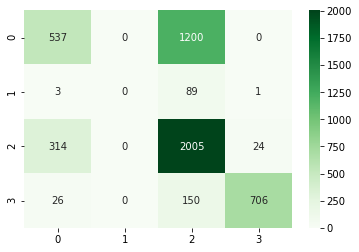

In [50]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_season_test,y_pred)
cm_df = pd.DataFrame(cm)

sns.heatmap(cm_df,cmap="Greens",fmt="d",annot=True)

## 2. KNN Classifier

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix

In [52]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_features_train,y_season_train)
y_pred = knn.predict(X_features_test)
print(accuracy_score(y_season_test,y_pred))
cm = confusion_matrix(y_season_test,y_pred)

0.5408506429277943


<AxesSubplot:>

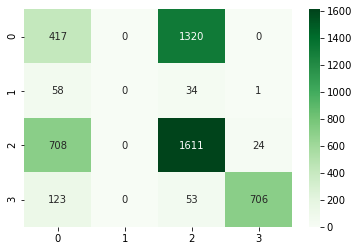

In [53]:
sns.heatmap(cm,annot=True,cmap="Greens",fmt="d")